In [1]:
from fastai.text import *


In [2]:
!wget https://raw.githubusercontent.com/Moximixi/Emotional-analysis-of-curriculum-review/main/%E9%BB%84%E5%BF%A0%E8%B4%A2/newtest.csv

--2021-03-30 10:52:07--  https://raw.githubusercontent.com/Moximixi/Emotional-analysis-of-curriculum-review/main/%E9%BB%84%E5%BF%A0%E8%B4%A2/newtest.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 843462 (824K) [text/plain]
Saving to: ‘newtest.csv’

newtest.csv         100%[===================>] 823.69K  --.-KB/s    in 0.02s   

2021-03-30 10:52:07 (42.1 MB/s) - ‘newtest.csv’ saved [843462/843462]



In [3]:

df = pd.read_csv("newtest.csv")
df=df.sample(frac=1.0)    #打乱数据集
df=df.reset_index(drop=True)
df[0:100]


,comment,sentiment
0,课程内容 丰富新颖，加强了教师职业道德。,1
1,知识点简洁明了,1
2,一个很好的科普天文的课程,1
3,通过学习更加懂得了如何应对新冠疫情防控,1
4,照着课本念。。。,0
...,...,...
95,明显是在完任务啊，一点诚意都木有,0
96,非常好的课程。这是第一次觉得线上的课程也有这么优质的，特别棒。,1
97,每位老师上课都讲得十分清楚，细致，值得学习！！！,1
98,辣鸡，这怎么不能看啊！还有哪个进度条怎么也满不了，真要命,0


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(df, test_size=.2, random_state=2)
train, valid = train_test_split(train, test_size=.2, random_state=2)
train.head()
#划分训练测试和验证集

,comment,sentiment
2041,老师讲课水平相当菜，完全照读PPT，要我讲我都比他讲的有激情。2min内鉴定完毕。。。,0
5492,讲的不行，下架吧别在这丢华科的人了,0
7112,传说中的PPT老师，内容严重过时，实在不敢相信还是国家精品,0
2620,坑课，填空题巨坑，念PPT都念错，声音还和猫一样小，武大的测绘出名不应该这么多PPT老师，数...,0
3585,慕课的质量都比较高，可以学到很多实用的知识。,1


In [6]:
!pip install pytorch-transformers

     |████████████████████████████████| 184kB 17.2MB/s 
     |████████████████████████████████| 1.2MB 44.4MB/s 
     |████████████████████████████████| 890kB 58.5MB/s 
     |████████████████████████████████| 102kB 12.3MB/s 
     |████████████████████████████████| 7.4MB 51.5MB/s 
     |████████████████████████████████| 81kB 10.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=255413f007106420fca4a43bdad46f8f68b381dda8617b7fdfed684fa4f949a5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
  Created wheel for boto3: filename=boto3-1.17.40-py2.py3-none-any.whl size=128777 sha256=a91fd3719f72a788cb38b6ca06e2e424902dac771efcb08c1419bbc9e5d66639
  Stored in directory: /root/.cache/pip/wheels/bd/6f/50/2aad26d403ab8ea8afdc92a5ce8abb2347b4a42c7d1be4ee79
Successfully built sacremoses boto3
ERROR: botocore 1.20.40 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which

In [7]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification

In [8]:
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32

In [9]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)  
#读取预置的 Tokenizer 

100%|██████████| 109540/109540 [00:00<00:00, 13016149.93B/s]


In [10]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [11]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))
#词汇列表存储

In [12]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [13]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)
#将类调用保存为函数

In [14]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)


In [15]:
path = Path(".") #设置路径

In [16]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
                  pin_memory=True,
                  num_workers = 1,
                  device=torch.device("cuda")
             )

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [17]:
databunch.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
[CLS] 追 评 ： 不 但 出 分 效 率 特 别 低 ， 而 且 不 明 不 白 太 疯 狂 少 了 10 分 （ 10 分 平 时 成 绩 是 什 么 鬼 ？ 如 果 是 讨 论 的 话 课 堂 交 流 区 一 个 讨 论 题 都 没 有 ？ ？ ） ， 课 程 团 队 很 不 负,0
[CLS] 我 是 一 名 普 通 的 战 士 ， 虽 然 没 学 过 唱 歌 ， 但 也 很 喜 欢 唱 歌 ， 所 以 看 到 林 老 师 这 门 课 时 我 毫 不 犹 豫 报 名 了 。 因 为 没 有 学 过 唱 歌 ， 平 日 唱 军 歌 、 喊 口 号 时 都 是 用 嗓,1
[CLS] 作 业 不 知 道 怎 么 布 置 的 ， 第 八 、 九 单 元 测 验 1 月 9 日 截 止 ， 往 后 的 第 十 单 元 测 验 放 出 来 没 几 天 12 月 13 日 截 止 。 逻 辑 鬼 才 。 对 非 专 业 的 学 生 极 度 不 友 好 ， 完 全 是,0
[CLS] 这 门 课 程 开 设 的 慕 课 ， 为 我 们 更 全 面 地 了 解 、 学 习 思 修 这 门 课 程 。 慕 课 中 的 老 师 通 过 视 频 讲 解 的 形 式 ， 生 动 形 象 地 讲 解 了 这 门 课 程 的 知 识 点 。 又 有 测 验 与 讨 论,1
[CLS] 每 一 章 都 有 导 学 案 ， 可 以 让 我 们 很 清 楚 的 知 道 该 干 什 么 ， 而 且 作 业 量 适 中 ， 能 起 到 很 好 的 学 习 作 用 。 每 一 章 都 有 详 尽 的 视 频 资 料 和 [UNK] 资 料 ， 可 以 看 出 老 师 们 很,1


In [18]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)  #2分类任务

100%|██████████| 411577189/411577189 [00:07<00:00, 58032391.22B/s]


In [19]:
loss_func = nn.CrossEntropyLoss()

In [20]:
learn = Learner(databunch,#数据
                bert_pretrained_model,#模型
                loss_func=loss_func,#损失函数
                metrics=accuracy)

In [21]:
learn.lr_find()#寻找最大学习速率

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


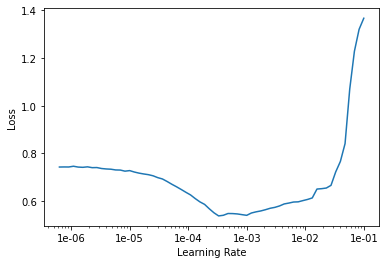

In [22]:
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(3,2e-5)
#模型准确度上升了0.03

epoch,train_loss,valid_loss,accuracy,time
0,0.213829,0.188341,0.948647,00:52
1,0.179373,0.168468,0.948647,00:48
2,0.131543,0.172907,0.953065,00:51


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [25]:
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['comment'])[1]))
  return preds

In [26]:
preds = dumb_series_prediction(len(test))

In [27]:
print(preds[40:60])
print(test[40:60])
#测试问题1：准确率相对较低
#2：向前参考可能较少

[0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0]
                                                 comment  sentiment
9704                                            下载不了是为什么          0
8628                                       大家的课是不是只有第一章啊          1
166                                       极好的课程，娓娓道来十分有趣          1
1220                                         这个平台真的是一言难尽          0
10440  老师光站在那里说，谁能知道，他到底在说具体版面上的哪个地方呢？应该用个小棒指出来自己讲的知识...          0
2997                                              总体来说不错          1
3047                 老师好！课太棒了！刘宪权教授的刑法学课程录像现在在哪里可以看？谢谢您！          1
6313   以前学过，但此次收获更多。\n尤其是10分钟左右的课程让人注意力集中，能够牢牢把握知识点，值...          1
2726                                          英语慕课使我受益匪浅          0
174                            照着ppt读，完全没有讲解的地方，语速还很快，差评          0
1259                                          课件很全，讲的也很好          1
10445                      感觉老师没有备课，讲得太枯燥，像是跟着ppt念，思维跟不上          0
6489                                        详细 ，简单，非常实用

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1065
           1       0.92      0.98      0.95      1198

    accuracy                           0.94      2263
   macro avg       0.94      0.94      0.94      2263
weighted avg       0.94      0.94      0.94      2263



In [30]:
print(confusion_matrix(test.sentiment, preds))

[[ 960  105]
 [  29 1169]]
